# JITコンパイラ-Numba

前の章で紹介したcffiとCythonは、C言語コンパイラを使用してC言語プログラムを拡張モジュールにコンパイルし、Pythonでその関数を呼び出す必要がありました。一方、NumbaはLLVMコンパイラを使用してPython関数を即座に機械語にコンパイルします。Numbaを使用する際には、コンパイルのステップをほとんど感じることがありません。ユーザーはPython関数に`@jit`デコレータを追加するだけで、Numbaはその関数が呼び出された際に、引数の型に基づいて自動的に効率的に実行されるプログラムをコンパイルします。

デフォルト設定では、即時コンパイル関数の内部でPythonオブジェクトが使用される可能性があり、これがプログラムの実行速度に影響を与えることがあります。`@jit`デコレータの`nopython`パラメータを`True`に設定するか、デフォルトでPythonオブジェクトを禁止する`@njit`デコレータを使用することができます。コンパイラがPythonオブジェクトを使用する必要があると判断した場合、コンパイル時に例外をスローし、潜在的なパフォーマンスの損失を捕捉します。コンパイラが引数の型および型推論に基づいてすべての変数の型を決定すると、Pythonオブジェクトを使用せずに、効率的に実行される機械語を生成することができます。

In [1]:
import helper.magics
import numba as nb
from numba import jit, njit, cfunc
from numba.types import double, int32, float32, float64, int64, uint8
from numba import types as T
import numpy as np

## データ型

Numbaは、効率的な計算を行う機械語を生成するために、計算に参加する各変数のデータ型を知る必要があります。NumbaはC言語の各種数値型、ポインタ型、NumPyの配列型、および構造体型をサポートしています。

### 関数シグネチャ

関数をより効率的な機械語にコンパイルするために、Numbaは関数の引数の型を知る必要があります。この型情報は関数の型シグネチャ（type signature）と呼ばれます。`@jit`デコレータで関数をデコレートする際、その最初の引数に関数シグネチャを指定することができます。指定されていない場合、その関数が初めて呼び出された際に、渡された値の型に基づいて自動的に作成されます。

以下の例では、即時コンパイル関数`dummy_func()`には3つの引数があります。異なる型の実引数でこの関数を2回呼び出すと、この関数に対して2回の即時コンパイルが行われます。その関数シグネチャ属性`signatures`から、2つの関数シグネチャがあることがわかります。最初の関数シグネチャでは、Pythonの整数、浮動小数点数、および文字列に対応する型はそれぞれ`int64`、`float64`、および`unicode_type`です。2番目の関数シグネチャでは、NumPyの各種スカラー値に対応する型はその`dtype`属性と一致し、NumPy配列の型は`array()`で表されます。

In [2]:
import numpy as np
from numba import jit


@njit
def dummy_func(x, y, z):
    return (x, y, z)


dummy_func(1, 2.0, "hello")
dummy_func(np.float32(10), np.uint8(1), np.zeros(10))
dummy_func.signatures

[(int64, float64, unicode_type),
 (float32, uint8, Array(float64, 1, 'C', False, aligned=True))]

`@jit`の最初の引数に関数シグネチャを指定する必要がある場合、まず型オブジェクトをロードし、これらのオブジェクトを使用して関数シグネチャを作成することができます。Numbaのすべての型は`numba.core.types`モジュールで定義されており、いくつかの一般的な型オブジェクトは`numba`から直接ロードすることもできます。型オブジェクトを呼び出し演算子`()`で呼び出すと、その型を返り値とする関数シグネチャオブジェクトが作成されます。例えば、以下のように定義された関数シグネチャの返り値の型は倍精度浮動小数点数で、その最初の引数は倍精度浮動小数点数、2番目の引数は32ビット整数です。

In [3]:
from numba import float64, int32, int16

float64(float64, int32)

(float64, int32) -> float64

使いやすさのために、`@jit`は文字列を使用して関数シグネチャを指定することもできます。以下の例では、`dummy_func()`には2つの関数シグネチャがあり、そのうち2番目のシグネチャは文字列で定義されています。

In [4]:
@njit([float64(float64, int32), "float32(float32, int16)"])
def dummy_func(arr, n):
    return 0


dummy_func.signatures

[(float64, int32), (float32, int16)]

`typeof()`を使用すると、Pythonオブジェクトに対応する型を取得できます。以下の例から、整数オブジェクト、浮動小数点数オブジェクト、および複素数に対応する型はそれぞれ`int64`、`float64`、および`complex128`であることがわかります。文字列オブジェクトに対応する型は`unicode_type`で、バイト列オブジェクトは読み取り専用のバイト配列型に対応します。NumPyのスカラー数値を使用すると、さまざまなビット数の数値を取得できます。タプルオブジェクトには2つの対応する型があります。すべての要素の型が同じ場合、それは`UniType`型に対応し、その型は要素の型と長さによって決定され、固定長の配列に相当します。要素の型が異なる場合、それは`Tuple`型に対応し、その型は各要素の型によって決定され、匿名の構造体に相当します。

In [5]:
import numba as nb

values = [
    1,
    2.0,
    1j,
    "hello",
    b"bindata",
    np.float32(10),
    np.zeros(3),
    (1, 2, 3),
    (1, 2.0),
]
for v in values:
    print(f"typeof( {repr(v):19s} ) : {nb.typeof(v)}")

typeof( 1                   ) : int64
typeof( 2.0                 ) : float64
typeof( 1j                  ) : complex128
typeof( 'hello'             ) : unicode_type
typeof( b'bindata'          ) : readonly bytes(uint8, 1d, C)
typeof( np.float32(10.0)    ) : float32
typeof( array([0., 0., 0.]) ) : array(float64, 1d, C)
typeof( (1, 2, 3)           ) : UniTuple(int64 x 3)
typeof( (1, 2.0)            ) : Tuple(int64, float64)


### 配列型

型オブジェクトの添字演算子`[]`を使用して、その型の要素を持つ配列型を作成できます。その使用方法はCythonの配列型と同じで、添字の要素は`:`または`::1`です。添字要素の数は配列の次元数を決定し、`::1`はその次元の要素がメモリ内で連続して保存されることを示します。以下では、異なる要素型を使用して、メモリ内の保存方法が異なる3つの2次元配列型を定義します。配列型は「array(要素型, 次元数, メモリ配置)」と表示されます。メモリの配置方法には3種類あります：CはC言語連続、FはFortran言語連続、Aはメモリ連続に関する情報がないことを示します。連続して保存される配列型を使用すると、配列要素へのアクセス速度が向上します。

In [6]:
from numba.types import int32, float32, float64

%C int32[::1, :]; float32[:, :]; double[:, ::1]

              int32[::1, :]                               float32[:, :]                                double[:, ::1]              
-----------------------------------------  -------------------------------------------  -------------------------------------------
Array(int32, 2, 'F', False, aligned=True)  Array(float32, 2, 'A', False, aligned=True)  Array(float64, 2, 'C', False, aligned=True)


`Array()`を使用して直接配列型を作成することもできます。以下では、C言語連続の3次元配列型を作成します：

In [7]:
from numba.types import Array

Array(float32, 3, "C")

Array(float32, 3, 'C', False, aligned=True)

NumPy配列には、配列の次元数、形状、要素間の間隔など、配列のさまざまな属性が保存されています。一方、C言語では通常、ポインタと長さを渡すことで配列を渡します。Numbaでは`CPointer`を使用してポインタ型を作成できます。以下の例では、`@cfunc`デコレータで`sum1d()`をデコレートし、コンパイルされた関数がC言語の呼び出しインターフェースを使用することを示します。その最初の引数は倍精度浮動小数点数配列の先頭アドレスへのポインタで、2番目の引数は要素の数です。`@cfunc`でコンパイルされた関数は通常、拡張ライブラリ内でコールバック関数として呼び出され、Pythonではその`ctypes`属性を使用してctypeの関数オブジェクトを取得し、それを使用して即時コンパイルされた関数を呼び出すことができます。NumPy配列を`@cfunc`でコンパイルされた関数に渡す際には、その先頭要素へのポインタに変換する必要があります。

In [8]:
from numba.types import CPointer


@cfunc(float64(CPointer(float64), int64))
def sum1d(xs, n):
    s = 0.0
    for i in range(n):
        s += xs[i]
    return s


print(sum1d.ctypes)
from ctypes import POINTER, c_double

arr = np.arange(0.0, 11.0)
sum1d.ctypes(arr.ctypes.data_as(POINTER(c_double)), len(arr))

55.0

### 構造体型

構造体はPythonには対応するオブジェクトがありませんが、`Record.make_c_struct()`を使用して直接構造体型を定義できます。その引数は、各フィールドの名前と型を記述したリストです。現在、`make_c_struct()`はスカラーデータ型と`NestedArray`で定義された固定形状の配列のみをサポートしています。以下の`Triangle`構造体の`xs`と`ys`フィールドは、形状が`(3,)`の倍精度浮動小数点数配列です。

In [9]:
from numba.types import Record, NestedArray

Point = Record.make_c_struct(
    [
        ("id", int32),
        ("x", float64),
        ("y", float64),
    ]
)

Triangle = Record.make_c_struct(
    [
        ("id", int32),
        ("xs", NestedArray(float64, (3,))),
        ("ys", NestedArray(float64, (3,))),
    ]
)

`Record`オブジェクトはNumPyの`dtype`オブジェクトと相互に変換できます。`Record`オブジェクトの`dtype`属性を使用して、それに対応する`dtype`オブジェクトを取得できます。また、`numpy_support.from_dtype()`を使用して`dtype`オブジェクトを`Recored`オブジェクトに変換できます。以下では、まず`dtype`オブジェクト`Line_dtype`を作成し、それを`Record`オブジェクトに変換します。その`x`と`y`フィールドは`Point`構造体です。現在、Numbaは要素型が構造体である`NestedArray`配列をサポートしていません。

In [10]:
from numba.np import numpy_support

Line_dtype = np.dtype([("id", np.int32), ("start", Point.dtype), ("end", Point.dtype)])
Line = numpy_support.from_dtype(Line_dtype)

以下では、型が`Line.dtype`の構造体配列を作成し、その`.view(np.recarray)`メソッドを呼び出して構造体を`recarray`配列に変換します。`recarray`配列と構造体配列の使用方法は同じですが、`recarray`配列はフィールドに属性でアクセスする機能を追加しています。即時コンパイル関数`length()`は、各構造体配列内の各線分の長さを計算します。引数が構造体配列であっても`recarray`配列であっても、Numbaの即時コンパイル関数内では属性名を使用してそのフィールドにアクセスできます。

In [11]:
@njit
def length(lines):
    x1 = lines.start.x
    x2 = lines.end.x
    y1 = lines.start.y
    y2 = lines.end.y
    return np.hypot(x2 - x1, y2 - y1)


lines = np.zeros(3, dtype=Line.dtype).view(np.recarray)

lines.start.x = [1, 2, 3]
lines.end.x = [10, 10, 10]
lines.start.y = [2, 2, 2]
lines.end.y = [8, 7, 6]

length(lines), length.py_func(lines)

(array([10.81665383,  9.43398113,  8.06225775]),
 array([10.81665383,  9.43398113,  8.06225775]))

### 関数を引数として

Numbaの即時コンパイル関数内では、他の即時コンパイル関数や動的リンクライブラリからロードされた外部関数を呼び出すことができます。さらに、これらの関数を引数として渡すこともサポートされています。以下の例では、`func()`は即時コンパイル関数で、`lib.sin()`は`cffi`モジュールを使用してC言語標準ライブラリからロードされた外部関数です。これら2つの関数を`sum_of_func()`に渡し、配列に対して演算を行った後の和を計算します。

In [12]:
from cffi import FFI


@njit
def func(x):
    return x * np.sin(x**2)


@njit
def sum_of_func(func, xs):
    s = 0.0
    for x in xs:
        s += func(x)
    return s


ffi = FFI()
ffi.cdef("double sin(double);")
lib = ffi.dlopen("msvcrt")

xs = np.linspace(0, 1, 1000)
print(sum_of_func(lib.sin, xs), sum_of_func(func, xs))

459.6586935836439 230.0398940446059


以下では、`sum_of_func()`の関数シグネチャを確認します。外部関数と即時コンパイル関数の呼び出し方法が異なるため、2つのシグネチャがあることがわかります。

In [13]:
for sig in sum_of_func.signatures:
    print(sig)

(ExternalFunctionPointer((float64,) -> float64), Array(float64, 1, 'C', False, aligned=True))
(type(CPUDispatcher(<function func at 0x0000018AF6E0AD40>)), Array(float64, 1, 'C', False, aligned=True))


即時コンパイル関数は実際には`CPUDispatcher`型のディスパッチャオブジェクトです。これは、異なる引数の型に対して異なる処理が必要なためです。即時コンパイル関数の各シグネチャには対応する機械語があり、呼び出し時の引数の型に基づいて適切な機械語を自動的に選択して実行します。この特性は関数のオーバーロードと呼ばれます。ディスパッチャオブジェクトの`overloads`属性には、シグネチャとコンパイルされた機械語の関係が保存されており、それは`OrderedDict`オブジェクトです。`get_overload()`メソッドを使用して、シグネチャに対応する機械語を取得できます。以下では、外部関数引数のシグネチャに対応するオーバーロード関数を取得し、それを呼び出します。

In [14]:
print(type(sum_of_func))
sum_of_func0 = sum_of_func.get_overload(sum_of_func.signatures[0])
sum_of_func0(lib.sin, xs)

<class 'numba.core.registry.CPUDispatcher'>


459.6586935836439

### 局所変数の型

即時コンパイル関数内では、局所変数の型は通常、関数の引数の型およびその使用方法に基づいて自動的に推論されます。`inspect_types()`メソッドを使用して、コンパイルされたNumba中間コードを確認できます。Numbaのコンパイルプロセスでは、まずPython関数をNumba中間コードにコンパイルし、次にLLVMの中間コードにコンパイルし、最後にLLVMが機械語にコンパイルします。Numbaの中間コードから、Numbaの型推論プロセスを確認できます。以下のプログラムでは、`float32`型の数値を`dummy_func()`に渡した後、そのNumba中間コードを確認します。

In [15]:
@njit
def inc(x):
    x += 1.0
    return x


inc(np.float32(0.0))
inc.inspect_types()

inc (float32,)
--------------------------------------------------------------------------------
# File: C:\Users\ruoyu\AppData\Local\Temp\ipykernel_21236\914538076.py
# --- LINE 1 --- 
# label 0
#   x = arg(0, name=x)  :: float32

@njit

# --- LINE 2 --- 

def inc(x):

    # --- LINE 3 --- 
    #   $const6.1.1 = const(float, 1.0)  :: float64
    #   x.1 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=x, rhs=$const6.1.1, static_lhs=Undefined, static_rhs=Undefined)  :: float64
    #   del x
    #   del $const6.1.1

    x += 1.0

    # --- LINE 4 --- 
    #   $16return_value.4 = cast(value=x.1)  :: float64
    #   del x.1
    #   return $16return_value.4

    return x




プログラムが出力するNumbaの中間コードによると、`inc()`の引数の型は`float32`ですが、`float64`型の定数`1.0`と演算するため、精度を保つために関数の戻り値の型は`float64`となります。

注意深い読者は、`x += 1.0`のコンパイル結果がC言語とは全く異なることに気付くかもしれません。加算代入演算は変数`x`に結果を代入するのではなく、新しい変数`x.1`に代入しています。これは、LLVMでは各変数は一度しか代入できないため、新しい変数を作成して演算結果を保存する必要があり、精度を失わないために新しい変数の型が`float64`に設定されているためです。

本書で提供されている`get_local_variables()`を使用すると、ローカル変数の型情報を簡単に取得できます。最初の引数は即時コンパイル関数で、2番目の引数は関数シグネチャのインデックスです。変数名をキー、変数の型を値とする辞書を返します。

In [16]:
from helper.numba import get_local_variables

get_local_variables(inc, 0)

{'arg.x': float32,
 'x': float32,
 'x.1': float64,
 '$16return_value.4': float64,
 '$const6.1.1': float64}

即時コンパイル関数では、Numbaの型オブジェクトまたはNumPyのスカラ型を使用して型変換を行うことができます。以下では、定数`1.0`を`float32`型に変換してから変数`x`と加算します。2つの`float32`型の浮動小数点数を加算した結果は`float32`型で表現できるため、関数の戻り値は`float32`型になります。

In [17]:
@njit
def inc(x):
    x += float32(1.0)
    return x


inc(np.float32(0.0))
get_local_variables(inc, 0)

{'arg.x': float32,
 'x': float32,
 'x.1': float32,
 '$18call.4': float32,
 '$34return_value.7': float32,
 '$6load_global.1': class(float32),
 '$const16.3.1': float64}

以下の`checksum()`は、1バイトの符号なし整数配列のチェックサムを計算します。このコードをC言語で実装すると、1バイトの整数を返します。しかし、Numbaでコンパイルされた関数は、配列内のすべての数の合計を返します。これは、2つの`uint8`型の整数を加算すると、その和が`uint8`の範囲を超えるため、Numbaが`uint64`を使用して合計を保存するためです。

In [18]:
@njit
def checksum(xs):
    s = uint8(0)
    for x in xs:
        s += uint8(x)
    return s


arr = np.arange(200).astype(np.uint8)
checksum(arr)

19900

以下は`checksum()`の各ローカル変数の型です。変数`s`は最初は`uint8`ですが、加算演算の後、その型は`uint64`に変わります：

In [19]:
get_local_variables(checksum, 0)

{'arg.xs': Array(uint8, 1, 'C', False, aligned=True),
 's': uint8,
 's.1': uint64,
 's.2': uint64,
 'x': uint8,
 'xs': Array(uint8, 1, 'C', False, aligned=True),
 '$28get_iter.5': iter(array(uint8, 1d, C)),
 '$30for_iter.1': pair<uint8, bool>,
 '$30for_iter.2': uint8,
 '$30for_iter.3': bool,
 '$38load_global.3': class(uint8),
 '$4load_global.0': class(uint8),
 '$50call.6': uint8,
 '$74return_value.3': uint64,
 '$binop_iadd58.7': uint64,
 '$const14.2.1': Literal[int](0),
 '$phi30.0': iter(array(uint8, 1d, C)),
 '$phi34.1': uint8}

正しいチェックサムを計算するためには、加算演算の結果の型を`uint8`に変換する必要があります：

In [20]:
@njit
def checksum2(xs):
    s = uint8(0)
    for x in xs:
        s = uint8(s + x)
    return s


checksum2(arr)

188

以下のローカル変数の型から、累積変数`s`のすべてのコピーの型が`uint8`になっていることがわかります。

In [21]:
get_local_variables(checksum2, 0)

{'arg.xs': Array(uint8, 1, 'C', False, aligned=True),
 's': uint8,
 's.1': uint8,
 's.2': uint8,
 'x': uint8,
 'xs': Array(uint8, 1, 'C', False, aligned=True),
 '$28get_iter.5': iter(array(uint8, 1d, C)),
 '$30for_iter.1': pair<uint8, bool>,
 '$30for_iter.2': uint8,
 '$30for_iter.3': bool,
 '$36load_global.2': class(uint8),
 '$4load_global.0': class(uint8),
 '$72return_value.3': uint8,
 '$binop_add48.6': uint64,
 '$const14.2.1': Literal[int](0),
 '$phi30.0': iter(array(uint8, 1d, C)),
 '$phi34.1': uint8}

### コンテナ型

Pythonのリストや辞書などのコンテナ型は、プログラムの作成に非常に便利です。これらは任意の型のオブジェクトを保存できますが、大量の同じ型のオブジェクトを処理する場合、不要なパフォーマンスの低下を引き起こすことがあります。Numbaは、型付きのリストコンテナ`List`と辞書コンテナ`Dict`を提供しています。これらのコンテナでは、すべての要素が同じメモリを占有するため、連続したメモリにすべての要素を保存し、コンテナのアクセス速度を向上させることができます。

以下の例では、`filter_between()`は`arr`内の`vmin`と`vmax`の間にある要素を収集します。条件を満たす要素の数がわからないため、プログラムでは`List`コンテナを使用して条件を満たす要素を1つずつ追加します。

In [22]:
from numba.typed import List


@njit
def filter_between(arr, vmin, vmax):
    r = List()
    for v in arr:
        if vmin < v < vmax:
            r.append(v)
    return r

以下では、`filter_between()`とPythonのリスト内包表記の速度を比較します。配列の反復処理が遅いため、まず配列をリストに変換してからリスト内包表記を使用して計算します：

In [23]:
values = np.random.randn(100000)
lvalues = values.tolist()
r1 = filter_between(values, 0.1, 0.11)
%timeit filter_between(values, 0.1, 0.11)
%timeit [x for x in lvalues if 0.1 < x < 0.11]

684 μs ± 21.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
7.54 ms ± 251 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Python環境では、`List`コンテナオブジェクトと組み込みのリストオブジェクトの使い方は同じです：

In [24]:
print(type(r1), len(r1), sum(r1))

<class 'numba.typed.typedlist.List'> 382 40.047751097787135


`_numba_type_`属性を使用して、Numbaでの型を確認できます。以下の出力から、`r1`の要素型は`float64`であることがわかります：

In [25]:
r1._numba_type_

ListType(float64)

以下の`group_mean()`は、辞書コンテナ`Dict`を使用して`group`と`arr`のデータをグループ化し、平均値を計算します。❶`List`とは異なり、即時コンパイル関数では`{}`が`Dict`オブジェクトを作成します。Numbaが`Dict`オブジェクトのキーと値の型を正しく推論するために、ここでは`group[0]`と`(0, 0.0)`を使用して辞書を初期化します。辞書のキーは`group`のグループ要素で、値はそのグループの要素数と`arr`内の対応する要素の合計を保存するためのタプルです。`group`と`arr`の各ペアに対してループし、❷辞書オブジェクトの`get()`メソッドを使用してグループに対応するデータを取得します。データがない場合は初期データを返します。❸グループの要素数と合計を更新します。最後に、この辞書を使用して各グループの平均値を計算します。

In [26]:
from numba.typed import Dict
from numba.types import int64, float64, Tuple


@njit
def group_mean(group, arr):
    d = {group[0]: (0, 0.0)}  #❶
    for g, v in zip(group, arr):
        n, s = d.get(g, (0, 0.0))  #❷
        d[g] = n + 1, s + v  #❸

    r = {}
    for key, val in d.items():
        r[key] = val[1] / val[0]
    return r

以下では、`group_mean()`の即時コンパイル関数、元のPython関数、およびPandasのグループ平均演算の速度を比較します。以下の結果から、即時コンパイル関数はPandasの演算速度に近いことがわかります。Pandas内部では、グループ平均演算はCythonで記述されたコンパイル関数を使用して実装されているため、その演算効率は非常に高いです。一部のグループ演算がPandasのコンパイル関数を使用できない場合、この例と同様の方法を使用して演算速度を向上させることができます。

In [27]:
import pandas as pd

values = np.random.randn(100000)
group = np.random.randint(0, 100, size=len(values), dtype=np.int16)
grp_means = group_mean(group, values)
lvalues = values.tolist()
lgroup = group.tolist()
%timeit group_mean(group, values)
%timeit group_mean.py_func(lgroup, lvalues)
%timeit pd.Series(values).groupby(group).mean()

6.01 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.3 ms ± 741 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.55 ms ± 126 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Python環境では、`Dict`オブジェクトの使い方は組み込みの辞書と同じです。以下では、`grp_means`の型とNumbaでの型を確認します：

In [28]:
print(type(grp_means), grp_means._numba_type_)

<class 'numba.typed.typeddict.Dict'> DictType[int16,float64]<iv=None>


以下では、`items()`メソッドを使用してキーと値のシーケンスを取得し、`sorted()`を使用してキーでソートします：

In [29]:
sorted(grp_means.items())[:4]

C:\pyenv313\envs\py\Lib\site-packages\numba\typed\typeddict.py:39: NumbaTypeSafetyWarning: unsafe cast from int64 to int16. Precision may be lost.
  return d[key]


[(0, -0.0410367552070842),
 (1, -0.02778984086324954),
 (2, 0.037509288678359134),
 (3, -0.023943960809716978)]

## NumPy配列演算

Numbaは配列型、配列計算式、およびNumPyで定義されたほとんどの関数を認識し、より効率的なコードを生成することができます。また、`@vectorize`デコレータを使用してNumPyのufunc関数を生成したり、`@stencil`デコレータを使用してテンプレートのカーネル関数を処理し、配列全体を処理する関数を生成することもできます。

### ブロードキャスト演算の最適化

NumPyは配列式を計算する際に、中間計算結果を保存するために多くの一時配列を作成します。演算に参加する配列が大きい場合、これらの一時配列のメモリ割り当てと解放が演算速度に影響を与えます。Numbaは配列演算式をループ演算のコードに変換し、各配列式はufunc関数に似たコードにコンパイルされます。これにより、中間結果を保存するための配列を作成する必要がなくなります。

In [30]:
@njit
def f1(x, y):
    return np.sin(x**2) + np.cos(y**2)


@njit
def f2(x, y):
    a = np.sin(x**2)
    b = np.cos(y**2)
    return a + b

Numbaは配列のブロードキャスト演算をサポートしていますが、ブロードキャスト演算は配列式全体に対して行われるため、この処理がプログラムの演算速度を低下させることがあります。以下の例では、配列`x`と`y`の形状がそれぞれ`(1000, 1)`と`(1, 1000)`であり、NumPyで式`sin(x**2) + cos(y**2)`を計算する場合、ブロードキャスト演算は最後の加算で実行され、`sin()`と`cos()`は1000回だけ計算されます。一方、`f1()`は式全体を1つのufunc関数としてコンパイルするため、ブロードキャスト演算は式全体に対して行われ、`sin()`と`cos()`関数はそれぞれ1000×1000回計算されます。結果からわかるように、NumPyの演算速度と中間結果を配列に保存する`f2()`の速度は同じですが、式全体に対してブロードキャスト演算を行う`f1()`はかなり遅くなります。

したがって、Numbaを使用して配列式を計算する際には、演算に参加する配列の形状に応じて最適化されたコードを使用することができます。

In [31]:
x, y = np.ogrid[-1:1:1000j, -1:1:1000j]
f1(x, y)
f2(x, y)
%timeit f1(x, y)
%timeit f2(x, y)
%timeit f1.py_func(x, y)

32.2 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.5 ms ± 123 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.45 ms ± 333 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


本書で提供されている`display_func_code()`を使用すると、Numbaが内部でサポートしているコンパイル関数のソースコードを確認できます。例えば、以下のように`np.nanmean()`のコードを確認できます：

In [32]:
from helper.numba import display_func_code


@nb.njit
def f(x):
    return np.nanmean(x)


x = np.random.randn(10)
f(x)
display_func_code(f, np.nanmean)

```python
# C:\pyenv313\envs\py\Lib\site-packages\numba\np\old_arraymath.py: 1199
@overload(np.nanmean)
def np_nanmean(a):
    if not isinstance(a, types.Array):
        return
    isnan = get_isnan(a.dtype)

    def nanmean_impl(a):
        c = 0.0
        count = 0
        for view in np.nditer(a):
            v = view.item()
            if not isnan(v):
                c += v.item()
                count += 1
        # np.divide() doesn't raise ZeroDivisionError
        return np.divide(c, count)

    return nanmean_impl

```

`display_func_code()`は、Pythonの演算子に対応するコンパイルコードを表示するためにも使用できます。例えば、以下のように加算演算に対応するコードを表示できます。プログラムの出力から、整数、浮動小数点数、および文字列の加算がそれぞれ異なる関数に対応していることがわかります。

In [33]:
import operator


@nb.njit
def f(a, b):
    return a + b


f("a", "b")
display_func_code(f, operator.add)

```python
# C:\pyenv313\envs\py\Lib\site-packages\numba\cpython\old_numbers.py: 614
def real_add_impl(context, builder, sig, args):
    res = builder.fadd(*args)
    return impl_ret_untracked(context, builder, sig.return_type, res)

```

```python
# C:\pyenv313\envs\py\Lib\site-packages\numba\cpython\old_numbers.py: 35
def int_add_impl(context, builder, sig, args):
    [va, vb] = args
    [ta, tb] = sig.args
    a = context.cast(builder, va, ta, sig.return_type)
    b = context.cast(builder, vb, tb, sig.return_type)
    res = builder.add(a, b, flags=_int_arith_flags(sig.return_type))
    return impl_ret_untracked(context, builder, sig.return_type, res)

```

```python
# C:\pyenv313\envs\py\Lib\site-packages\numba\cpython\old_numbers.py: 614
def real_add_impl(context, builder, sig, args):
    res = builder.fadd(*args)
    return impl_ret_untracked(context, builder, sig.return_type, res)

```

```python
# C:\pyenv313\envs\py\Lib\site-packages\numba\cpython\old_numbers.py: 35
def int_add_impl(context, builder, sig, args):
    [va, vb] = args
    [ta, tb] = sig.args
    a = context.cast(builder, va, ta, sig.return_type)
    b = context.cast(builder, vb, tb, sig.return_type)
    res = builder.add(a, b, flags=_int_arith_flags(sig.return_type))
    return impl_ret_untracked(context, builder, sig.return_type, res)

```

```python
# C:\pyenv313\envs\py\Lib\site-packages\numba\cpython\old_tupleobj.py: 29
@lower_builtin(operator.add, types.BaseTuple, types.BaseTuple)
def tuple_add(context, builder, sig, args):
    left, right = [cgutils.unpack_tuple(builder, x) for x in args]
    res = context.make_tuple(builder, sig.return_type, left + right)
    # The tuple's contents are borrowed
    return impl_ret_borrowed(context, builder, sig.return_type, res)

```

```python
# C:\pyenv313\envs\py\Lib\site-packages\numba\cpython\unicode.py: 1881
@overload(operator.add)
@overload(operator.iadd)
def unicode_concat(a, b):
    if isinstance(a, types.UnicodeType) and isinstance(b, types.UnicodeType):
        def concat_impl(a, b):
            new_length = a._length + b._length
            new_kind = _pick_kind(a._kind, b._kind)
            new_ascii = _pick_ascii(a._is_ascii, b._is_ascii)
            result = _empty_string(new_kind, new_length, new_ascii)
            for i in range(len(a)):
                _set_code_point(result, i, _get_code_point(a, i))
            for j in range(len(b)):
                _set_code_point(result, len(a) + j, _get_code_point(b, j))
            return result
        return concat_impl

    if isinstance(a, types.UnicodeType) and isinstance(b, types.UnicodeCharSeq):
        def concat_impl(a, b):
            return a + str(b)
        return concat_impl

```

```python
# C:\pyenv313\envs\py\Lib\site-packages\numba\cpython\charseq.py: 375
@overload(operator.add)
@overload(operator.iadd)
def charseq_concat(a, b):
    if not _same_kind(a, b):
        return
    if (isinstance(a, types.UnicodeCharSeq) and
            isinstance(b, types.UnicodeType)):
        def impl(a, b):
            return str(a) + b
        return impl
    if (isinstance(b, types.UnicodeCharSeq) and
            isinstance(a, types.UnicodeType)):
        def impl(a, b):
            return a + str(b)
        return impl
    if (isinstance(a, types.UnicodeCharSeq) and
            isinstance(b, types.UnicodeCharSeq)):
        def impl(a, b):
            return str(a) + str(b)
        return impl
    if (isinstance(a, (types.CharSeq, types.Bytes)) and
            isinstance(b, (types.CharSeq, types.Bytes))):
        def impl(a, b):
            return (a._to_str() + b._to_str())._to_bytes()
        return impl

```

### 配列のイテレーション

Numbaは、Python標準のイテレーション関数`iter()`や`enumerate()`に加えて、NumPyの3つのイテレーション関数である`np.ndenumerate()`、`np.nditer()`、`np.ndindex()`をサポートしています。NumPyでは大きな配列に対するイテレーションは処理速度が低下しがちですが、Numbaではそのような心配はありません。

* `ndenumerate()`は、要素のインデックスと要素の値を同時に取得できます。イテレーション要素は2つの要素を含むタプルで、最初の要素は`UniTuple(int64, ndim)`型のインデックス（`ndim`は配列の次元数）、2番目の要素は配列のdtypeに応じた要素の値となります。

* `nditer()`は、複数の配列に対してブロードキャストしながらイテレーションを行うことができます。イテレーションの各値は、次元が0の配列（`array(dtype, 0d, C)`型）として提供され、対応する要素にアクセスするには`item()`や`itemset()`メソッドを使用する必要があります。現在、`nditer()`は形状の左側に次元を追加するブロードキャストのみをサポートしており、例えば`(2, 3)`と`(5, 2, 3)`のブロードキャストは可能ですが、`(1, 3)`と`(4, 1)`のブロードキャストは例外をスローします。完全なブロードキャスト機能を使用したい場合は、`np.broadcast_arrays()`でブロードキャストした配列を即時コンパイル関数に渡すことができます。

* `ndindex()`は、配列の形状を表すタプルをパラメータとして受け取ります。イテレーション要素は`UniTuple(int64, ndim)`型で、`ndim`は形状タプルの長さに対応します。この関数を利用することで、多重ループのコードを簡素化できます。

次のプログラムでは、Numba を用いて平均二乗誤差の平方根（RMSE）を計算する2つの関数 `rmse()` と `rmse2()` を実装し、それらの性能を比較します。  

`rmse()` では、`np.nditer()` を使用して `arrx` と `arry` の要素を 1 つずつ取り出し、それぞれの差の二乗和を計算しています。また、`x.item()` と `y.item()` を用いることで、0 次元の NumPy 配列から Python のスカラー値を取得します。  

`rmse2()` では、NumPy のブロードキャスト機能を利用して `arrx` と `arry` の要素ごとの差を直接計算し、その二乗平均を求めた後に平方根を取っています。この関数は NumPy のベクトル演算を活用するため高速ですが、`rmse()` よりも遅くなることがあります。その主な原因は、計算の中間結果を保存する配列のメモリの割り当てと解放によるオーバーヘッドです。  

In [34]:
@njit
def rmse(arrx, arry):
    s = 0.0
    c = 0
    for x, y in np.nditer((arrx, arry)):
        x = x.item()
        y = y.item()
        s += (x - y) ** 2
        c += 1
    return (s / c) ** 0.5


@njit
def rmse2(arrx, arry):
    return np.mean((arrx - arry) ** 2)


x, y = np.ogrid[0:1:1000j, -1:1:2000j]
x, y = np.broadcast_arrays(x, y)
x.flags.writeable = False
y.flags.writeable = False
rmse(x, y)
rmse2(x, y)
%timeit np.mean((x-y)**2)
%timeit rmse(x, y)
%timeit rmse2(x, y)

18 ms ± 775 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.68 ms ± 48.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.7 ms ± 610 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


次の `find_hypotenuse()` は、指定された 3 次元の形状 (`shape`) の範囲内で、直角三角形の斜辺の長さが整数となる **ピタゴラス数** を探す関数です。三重ループの代わりに、`np.ndindex(shape)` を使用して、`shape` で指定された範囲 `(X, Y, Z)` 内のすべての `(x, y, z)` の組み合わせを走査します。

In [35]:
@jit
def find_hypotenuse(shape):
    res = []
    for x, y, z in np.ndindex(shape):
        if x == 0 or y == 0 or z == 0:
            continue

        if x * x + y * y == z * z:
            res.append((x, y, z))
    return res

次は速度の比較です。JIT コンパイル版は、約300倍高速になっています。

In [36]:
find_hypotenuse((2, 2, 2))
%time a = find_hypotenuse((100, 100, 100))
%time b = find_hypotenuse.py_func((100, 100, 100))
print(a == b)

CPU times: total: 0 ns
Wall time: 2.32 ms
CPU times: total: 562 ms
Wall time: 596 ms
True


(numba-vectorize)=
## `vectorize`でufunc関数を作成

Numba の `vectorize` を使用すると、スカラーの入力引数を取る Python 関数を NumPy の ufunc関数として利用できます。`vectorize()` デコレーターを使用すると、Numba は純粋な Python 関数をコンパイルし、C 言語で書かれた従来の ufunc と同等の速度で NumPy 配列上で動作する ufunc に変換できます。

`vectorize()` を使用する場合、関数は配列ではなくスカラーの入力に対して動作するように記述します。Numba は周囲のループを自動的に生成し、実際の入力データに対して効率的な繰り返し処理を行います。

`vectorize()` デコレーターには、次の 2 つの動作モードがあります。

1. **装飾時コンパイル**:  
   デコレーターに 1 つ以上の型シグネチャを渡すと、NumPy のufunc関数を構築します。このサブセクションでは、装飾時コンパイルを使用して ufunc を作成する方法について説明します。

2. **呼び出し時コンパイル**:  
   型シグネチャを指定しない場合、デコレーターは Numba の動的ufunc関数を作成します。これは、サポートされていない入力型が渡された際に、新しいカーネルを動的にコンパイルします。

次のコードは、`vectorize` を使って 2 つの数値の平方差を計算する ufunc を定義しています。`float64(float64, float64)` により、関数の引数と出力のデータ型を指定します。`ogrid` を使用すると、メモリを効率的に活用しながら 2D グリッドを作成できます。これにより、ufunc のブロードキャスト機能を確認できます。

In [37]:
from numba import vectorize, float64


@vectorize([float64(float64, float64)])
def sq_diff(a, b):
    return (a - b) ** 2


x, y = np.ogrid[-1:1:10j, -1:1:5j]
np.allclose(sq_diff(x, y), (x - y) ** 2)

True

次は、NumPy のコードとの計算時間を比較します。

In [38]:
%timeit (x - y)**2
%timeit sq_diff(x, y)

5.34 μs ± 352 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.92 μs ± 369 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


`vectorize` で作成した ufunc が必ずしも NumPy の式より高速になるとは限りません。次のコードでは、`x` と `y` にブロードキャストを適用する前に `sin`、`cos`、および二乗を計算し、その後ブロードキャストを利用して足し算を行います。  一方、Numba の ufunc を使用する場合は、先にブロードキャストを適用し、各要素のペアごとに `f1` の式を実行するため、計算速度が遅くなることがあります。  

In [39]:
@vectorize([float64(float64, float64)])
def f1(x, y):
    return np.sin(x**2) + np.cos(y**2)


x, y = np.ogrid[-1:1:1000j, -1:1:1000j]
%timeit f1(x, y)
%timeit np.sin(x**2) + np.cos(y**2)

26.9 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.52 ms ± 127 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`mgrid`で作成した2次元の配列に対しては、`f1()`の方は計算速度が速くなります。

In [40]:
x, y = np.mgrid[-1:1:1000j, -1:1:1000j]
%timeit f1(x, y)
%timeit np.sin(x**2) + np.cos(y**2)

19.8 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
30 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


`vectorize` で作成した ufunc は、NumPy の ufunc が持つすべての属性とメソッドをサポートします。例えば、以下の `weighted_add()` 関数を ufunc に変換し、その `accumulate()` メソッドを使用すると、ノイズのあるデータに対してローパスフィルタを適用できます。この結果は、`scipy.lfilter()` による処理結果と同じになります。

:::{note}
このデジタルフィルタの伝達関数は、差分方程式  

$$
y[n] = 0.1 x[n] + 0.9 y[n-1]
$$

に対応するZ 変換を用いて求められます。  

伝達関数$H(z)$は以下のようになります：

$$
H(z) = \frac{Y(z)}{X(z)} = \frac{0.1}{1 - 0.9z^{-1}}
$$

これは1 次の IIRフィルタであり、指数移動平均を実装するフィルタです。
:::

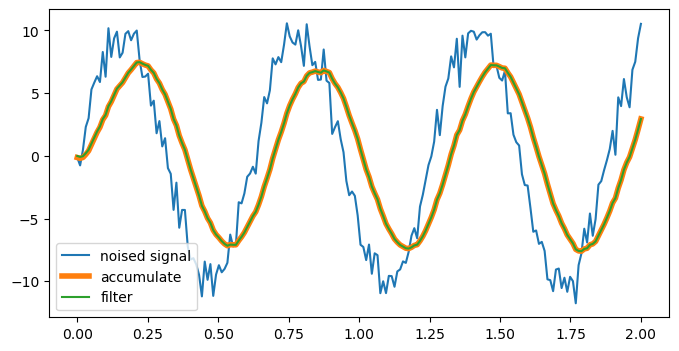

In [41]:
from matplotlib import pyplot as plt
from scipy import signal


@nb.vectorize([nb.float64(nb.float64, nb.float64)])
def weighted_add(x, y):
    return 0.9 * x + 0.1 * y


t = np.linspace(0, 2, 200)
x = np.random.randn(len(t)) + np.sin(10 * t) * 10
plt.figure(figsize=(8, 4))
plt.plot(t, x, label="noised signal")
plt.plot(t, weighted_add.accumulate(x), lw=4, label="accumulate")
plt.plot(t, signal.lfilter([0.1], [1, -0.9], x), label="filter")
plt.legend();

## ステンシルカーネルの作成

ステンシルは、配列の要素が特定のパターン（ステンシルカーネルと呼ばれる）に従って更新される一般的な計算パターンです。Numba は、ユーザーがステンシルカーネルを簡単に指定できるように、`@stencil` デコレーターを提供しています。これにより、Numba はそのカーネルを入力配列に適用するためのループコードを自動生成します。したがって、`@stencil` デコレーターを使用すると、コードがより明確で簡潔になり、並列実行のための `jit` オプションと組み合わせることで、ステンシル実行の並列化による高いパフォーマンスが実現できます。

次のコードは、`@stencil` デコレーターを使用して、2 次元配列の周囲の要素の平均を計算するカーネル関数を作成するものです。`mean_kernel` 関数は、2 次元配列 `a` を入力として受け取り、現在の要素（`a[0, 0]`）とその周囲の 4 つの隣接する要素（右、下、左、上）の合計の平均を計算します。具体的には、次の要素が加算されています：

- `a[0, 1]`: 右
- `a[1, 0]`: 下
- `a[0, -1]`: 左
- `a[-1, 0]`: 上
- `a[0, 0]`: 現在の要素

そして、それらの値に `0.2` を掛けることで平均を計算しています。要素が範囲外の場合は、カーネル関数が代わりに0を埋めることで処理します。

In [42]:
from numba import stencil


@stencil
def mean_kernel(a):
    return 0.2 * (a[0, 1] + a[1, 0] + a[0, -1] + a[-1, 0] + a[0, 0])


arr = np.random.randint(0, 10, size=(5, 5))
arr2 = mean_kernel(arr)
%C arr;arr2

       arr                     arr2           
-----------------  ---------------------------
[[0, 4, 9, 7, 3],  [[0. , 0. , 0. , 0. , 0. ],
 [7, 2, 7, 5, 3],   [0. , 4. , 4.8, 5.2, 0. ],
 [9, 0, 1, 4, 4],   [0. , 3.4, 3.4, 3.2, 0. ],
 [2, 5, 5, 2, 6],   [0. , 4.2, 4. , 5.2, 0. ],
 [9, 9, 7, 9, 0]]   [0. , 0. , 0. , 0. , 0. ]]


`@stencil` で得られるのは `StencilFunc` オブジェクトであり、`StencilFunc` は呼び出し時に JIT コンパイルを行います。しかし、キャッシュ機能が実装されていないため、現状ではそのまま `stencil` 関数を呼び出すのは遅くなります。

本書では `StencilFunc` に `create()` メソッドを追加し、このメソッドがコンパイル済みの関数を返すようにします。このコンパイル済み関数を呼び出すことで、実行速度が向上します。

:::{seealso}
https://github.com/numba/numba/issues/6706

`StencilFunc` のキャッシュ機能がないことに関する不具合報告です。
:::

In [43]:
import helper.numba  # StencilFuncにcreate()メソッドを追加

### 水波のシミュレーション

`stencil` を使って、水波のシミュレーションを高速化してみます。

水波のシミュレーションでは、次のステップの値を計算するために現在の値（`u[1]`）と一ステップ前の値（`u[2]`）を使用します。次のコードは、`u[1]`と`u[2]`の値を使って `u[0]` を算出します。`u[0]` は次のステップの値、`u[1]` は現在の値、`u[2]` は一ステップ前の値です。具体的には、中心の点における値はその周囲の隣接する4つの点の平均と現在の値との差分を使って更新され、時間の進行に伴って水波の動きが計算されます。

参照サイト: [2D Wave Equation Simulation](https://beltoforion.de/en/recreational_mathematics/2d-wave-equation.php)

次のコードでは、`u[0, c, r]` が次のステップで計算される水波の値を示し、`u[1, c, r]` と `u[2, c, r]` がそれぞれ現在の水波の状態と一ステップ前の状態を表します。

```python
for c in range(1, dimx-1):
    for r in range(1, dimy-1):
        u[0, c, r]  = 0.25 * (u[1, c-1, r] + u[1, c+1, r] + u[1, c, r-1] + u[1, c, r+1] - 4*u[1, c, r])
        u[0, c, r] += 2 * u[1, c, r] - u[2, c, r]
```

この方法で、2次元の波の進行がシミュレートされ、時間が経過するごとに水波の挙動が更新されます。

次のコードでは、`@stencil` デコレーターを使用して、2次元配列の周囲の要素を使用して水波のシミュレーションに使うカーネル関数を定義しています。関数 `kernel` の引数は

- `u` と `u2` は、2次元の配列で、現在の状態 (`u`) と一ステップ前の状態 (`u2`) を表しています。
- `dump` は定数または係数で、計算結果に掛け算されます。

`r` は水波の更新量を示し、次のように計算されます：

- `u[-1, 0]`: 上の隣接点
- `u[1, 0]`: 下の隣接点
- `u[0, -1]`: 左の隣接点
- `u[0, 1]`: 右の隣接点
- `u[0, 0]`: 現在の点（中央の点）
- `u2[0, 0]`: 中央の点の前の値
  
これらの値を使って、中心点の更新量を計算しています。最後に、`r` に `dump` を掛けて、シミュレーションの結果を調整しています。`dump` は減衰の役割を果たします。

`@stencil` は、関数をステンシル形式で定義し、Numba がその関数を最適化して効率的に適用できるようにします。このデコレーターにより、Numba はカーネル関数を並列計算用に最適化し、配列全体に効率的に適用できます。

In [44]:
@stencil
def kernel(u, u2, dump):
    r = 0.25 * (u[-1, 0] + u[1, 0] + u[0, -1] + u[0, 1] - 4 * u[0, 0])
    r += 2 * u[0, 0] - u2[0, 0]
    return r * dump

ダミーデータを使ってステンシルカーネルをコンパイルし、その結果を `f` とします。

In [45]:
u = np.zeros((3, 3))
u2 = np.zeros((3, 3))
f = kernel.create(u, u2, 0.1)

次は100x100の配列に対して、水波のシミュレーションを行います。20フレームごとにその結果をmatplotlibで描画します。

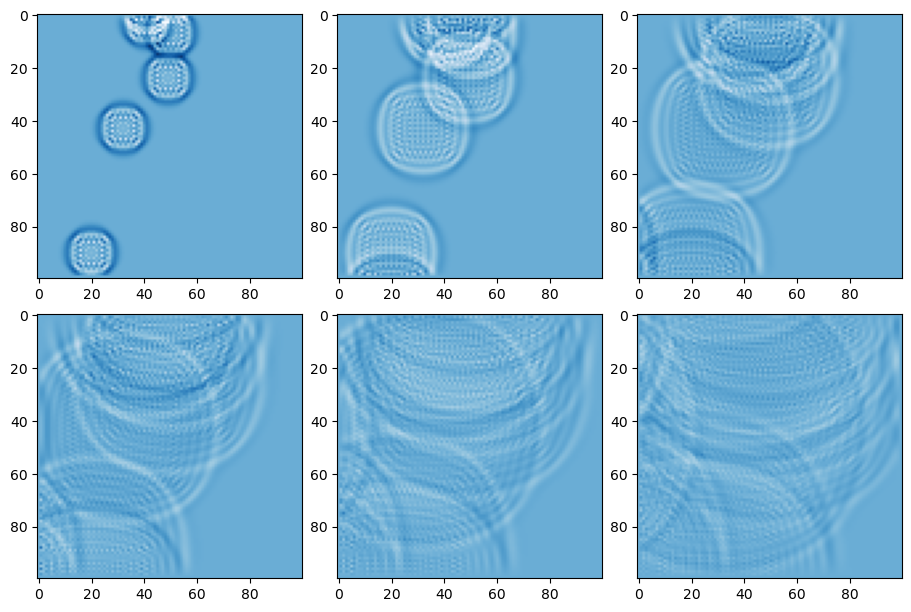

In [46]:
h, w = 100, 100
u = np.zeros((h, w))
n = 5
u[np.random.randint(0, h - 1, n), np.random.randint(0, w - 1, n)] = 120
u2 = np.zeros((h, w))

fig, axes = plt.subplots(2, 3, figsize=(9, 6), layout="constrained")

for ax in axes.ravel():
    for i in range(20):
        u_next = f.entry_point(u, u2, 0.99)
        u, u2 = u_next, u
    ax.imshow(u, cmap="Blues", vmin=-20, vmax=20)

最後に、panelを使って水波のアニメーションを作成します。

In [47]:
import cv2
from random import randint
from matplotlib.cm import Blues
from matplotlib.colors import Normalize
from IPython.display import display
import panel as pn

pn.extension()

次のコードは、水波シミュレーションのクラス`WaterSim`を定義し、シミュレーションの結果をリアルタイムで表示します。

- **`__init__`**: シミュレーションの初期化を行います。初期状態として水波を中央に設定し、`self.u`と`self.u2`としてそれぞれ現在の状態と1ステップ前の状態を保持します。
- **`get_png`**: 水波の状態`self.u`をカラーマップで変換し、PNG形式にエンコードして返します。
- **`update`**: シミュレーションを1ステップ更新します。ランダムに波を追加し、ステンシルカーネルで次の状態を計算します。
- **`show`**: 現在の水波の状態を画像として表示します。
- **`run`**: 定期的に`update`メソッドを実行し、水波シミュレーションを進めます。指定した秒数（デフォルトは5秒）間シミュレーションを実行します。

このコードは、`Panel`ライブラリを使用して、シミュレーションの進行状況をリアルタイムで表示します。

:::{warning}
このアニメーションはPythonの計算コアが必要なため、ウェブページ上ではアニメーションが表示されません。
:::

PNG(bytes)
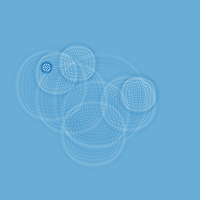

In [48]:
class WaterSim:
    def __init__(self, h, w, dump=0.99):
        self.h, self.w = h, w
        self.dump = dump
        u = np.zeros((h, w))
        u[h // 2, w // 2] = 120  # 初期状態として中央に波を設定
        u2 = np.zeros((h, w))
        self.u = u
        self.u2 = u2
        self.norm = Normalize(vmin=-40, vmax=40, clip=True)  # 正規化
        self.cmap = Blues  # カラーマップ
        self.image = pn.pane.PNG(self.get_png())  # PNG画像として表示
        for i in range(100):
            self.update()

    def get_png(self):
        arr2 = self.cmap(self.norm(self.u), bytes=True)[
            :, :, 2::-1
        ]  # カラーマップの適用
        flag, img = cv2.imencode(".png", arr2)  # PNGエンコード
        png = img.tobytes()  # バイトデータに変換
        return png

    def update(self):
        h, w = self.h, self.w
        if randint(0, 10) == 0:  # ランダムに初期値を追加
            self.u[randint(h // 5, h - h // 5), randint(w // 5, w - w // 5)] = 120

        u_next = f.entry_point(
            self.u, self.u2, self.dump
        )  # ステンシルカーネルで次の状態を計算
        self.u, self.u2 = u_next, self.u  # 現在の状態を更新
        self.image.object = self.get_png()  # 画像を更新

    def show(self):
        display(self.image)  # 画像を表示

    def run(self, seconds=5):
        self.cb = pn.state.add_periodic_callback(
            self.update, 20, timeout=seconds * 1000
        )  # 定期的に`update`メソッドを実行


sim = WaterSim(200, 200, dump=0.99)  # 200x200のシミュレーションを作成
sim.show()  # シミュレーションを表示
sim.run(seconds=10)  # 10秒間シミュレーションを実行

In [49]:
sim.run(seconds=10)  # 次の10秒をシミュレーションします。